# A work example for qixiang.TopoGrid, qixiang.Flow, qixiang.Stream

These codes (*topogrid.py, flow.py, stream.py*) are written by reorganizing the codes (*grid.py, flow.py, network.py*) from repo [geolovic/topopy](https://github.com/geolovic/topopy) by [José Vicente Pérez Peña](https://scholar.google.es/citations?user=by5rTEUAAAAJ&hl=es) from Universidad de Granada, Granada, Spain, and adding some functions which function like *klargestconncomps.m* and *trunk.m* from TopoToolbox matlab codes by Wolfgang Schwanghart.
                
Cite:   

Schwanghart, W., Scherler, D., 2014. Short Communication: TopoToolbox 2 - MATLAB-based software for topographic analysis and modeling in Earth surface sciences. Earth Surf. Dyn. 2, 1–7. https://doi.org/10.5194/esurf-2-1-2014


In [1]:
import sys 
sys.path.append("..") 

from qixiang import TopoGrid
from qixiang import Flow
from qixiang import Stream

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# 1. TopoGrid

Class for holding and manipulating gridded data. 

This class is reorganized the Class PRaster(), Grid(), DEM() in grid.py from repo [geolovic/topopy](https://github.com/geolovic/topopy)

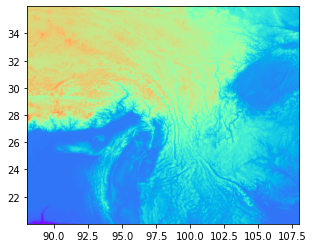

In [3]:
input_file = "../data/dem/TRR_Earth2014.TBI2014.1min.order10800.tif"
topo = TopoGrid(input_file)
topo.plot()

# 2. Flow

Class that define a network object (topologically sorted giver-receiver cells). 

This class is reorganized the Class Flow() in flow.py from repo [geolovic/topopy](https://github.com/geolovic/topopy)

The algoritm to created the topologically sorted network has been adapted to Python from FLOWobj.m by Wolfgang Schwanghart (version of 17. August, 2017) included in TopoToolbox matlab codes. 

### How the pixels are sorted in flow.py from repo [geolovic/topopy](https://github.com/geolovic/topopy)

Sort the pixels and get _ix (giver) and _ixc (receiver)

```python
class Flow(PRaster):

    def __init__(self, dem="", auxtopo=False, filled=False, verbose=False, verb_func=print):

        self._ix, self._ixc = sort_pixels(dem, auxtopo=auxtopo, filled=filled, verbose=verbose, verb_func=verb_func)
```   

1. Fill the sinks

   Algoritm: skimage.morphology.reconstruction
   
   
2. Get the flats and sills

   Flats are defined  as cells without downward neighboring cells. Sills are cells where flat regions spill over into lower terrain.

   Algoritm: identifyflats.m in TopoToolbox (ndimage.morphology.grey_erosion, ndimage.morphology.grey_dilation)
   

3. Get presills 

   presills are pixels immediately upstream to sill pixels.
 
   ```python
   presills_pos = get_presills(dem_arr, flats, sills)
   ```
   
   Algoritm: from TopoToolbox 
   

4. Get the auxiliar topography for the flats areas    

   ```python
   topodiff = get_aux_topography(topodiff.astype(np.float32), flats.astype(np.int8))
   ```
  
5. Get the weights inside the flat areas

   Calculate weights in the flats areas by doing a cost-distance analysis.It uses presill positions as seed locations, and an auxiliar topography as friction surface.
    
   ```python 
   weights = get_weights(flats, topodiff, presills_pos)
   ```

   Algoritm: from TopoToolbox (skimage.graph.MCP_Geometric)
   
   
6. Sort pixels (givers) 

   ```python
   ix = sort_dem(dem_arr, weights)
   ```
   
   Algoritm: from TopoToolbox
   

7. Get receivers

   ```python
   ixc = get_receivers(ix, dem_arr, cellsize)
   ```
   Algoritm: from TopoToolbox

In [4]:
flow = Flow(topo, auxtopo=False, filled=False, verbose=True, verb_func=print)
#flow = Flow(topo, auxtopo=False, filled=True, verbose=True, verb_func=print)

1/7 - DEM filled
2/7 - Flats and sills identified
3/7 - Presills identified
4/7 - Auxiliar topography generated
5/7 - Weights calculated
6/7 - Pixels sorted
7/7 - Receivers calculated


In [5]:
flowcc = flow.get_flow_accumulation()

extent = flowcc.get_extent()
res_area = 2
xticks_area = np.arange(extent[0],extent[1]+res_area/2,res_area)
yticks_area = np.arange(extent[2],extent[3]+res_area,res_area)

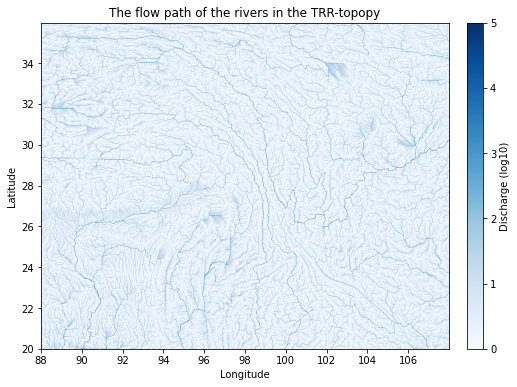

In [6]:
#flow_arr = flowcc.read_array()
if flowcc._nodata:
    mask = flowcc._array == flowcc._nodata
    flow_arr = flowcc._array.copy()
    flow_arr[mask] = flow_arr.min()
    #flow_arr = np.ma.array(flowcc._array, mask = mask)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the rivers in the TRR-topopy')

#im = ax.imshow(flow_arr,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000)
im = ax.imshow(np.log10(flow_arr),extent=extent,cmap=cm.Blues,vmin=0, vmax=5)

cbar= plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Discharge (log10)')

plt.savefig(('TRR_Flowpath_nofill.png'),dpi=300)
plt.show()

# 3. Stream

Class that define a stream network object, defined by applying a threshold to a flow accumulation raster derived from the *Flow* (Flow.get_flow_accumulation()).

This class is based on the Class Network() in network.py from repo [geolovic/topopy](https://github.com/geolovic/topopy), and added some new funtions which can function as *klargestconncomps.m* and *trunk.m* from TopoToolbox matlab codes by Wolfgang Schwanghart.


In [7]:
# min_area = 0.0005
# threshold = int(flow._ncells * min_area)
threshold = 500
stream = Stream(dem=topo, flow=flow, threshold=threshold, verbose=False, thetaref=0.45, npoints=5)

#streams = stream.get_streams(asgrid=False)
#streams_seg = stream.get_stream_segments(asgrid=False)
#streams_or = stream.get_stream_order(kind="shreeve", asgrid=False)
str_or0 = stream.get_stream_order(kind="strahler", asgrid=False)

In [8]:
print(threshold)
print(flow._ix.shape)
print(stream._ix.shape)

500
(1151508,)
(35681,)


## Test get_klargestconncomps

In [9]:
ccs_arr,ccs_id = stream.get_klargestconncomps(k=5,asgrid=False)
#ccs_arr = ccs._array.copy()
#extent = stream.get_extent()

In [10]:
ccs_id 

array([28,  6, 21, 37, 35])

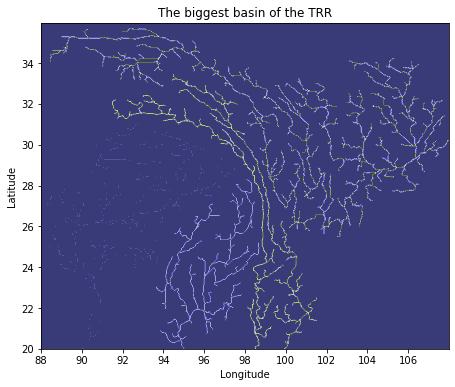

In [11]:
data_img = ccs_arr

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The biggest basin of the TRR')
ax.imshow(data_img,extent=extent,cmap=cm.tab20b)

## Test get_trunk

In [12]:
ccs_arr,ccs_id = stream.get_klargestconncomps(k=5,asgrid=False)

In [13]:
ccs_id

array([28,  6, 21, 37, 35])

In [14]:
trunk_arr2 = stream.get_trunk(ccs_arr,ccs_id)

In [15]:
stream.get_trunk_output(trunk_arr2,path='../data/data_rivers/qixiang/')

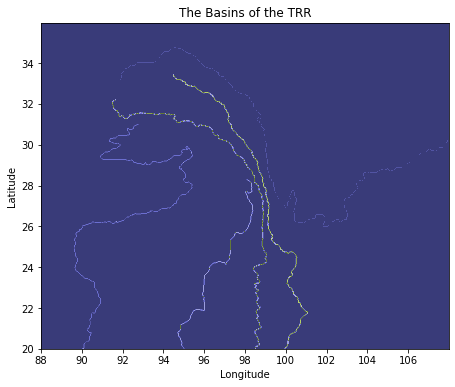

In [16]:
data_img = trunk_arr2

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The Basins of the TRR')

ax.imshow(data_img,extent=extent,cmap=cm.tab20b)

/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)


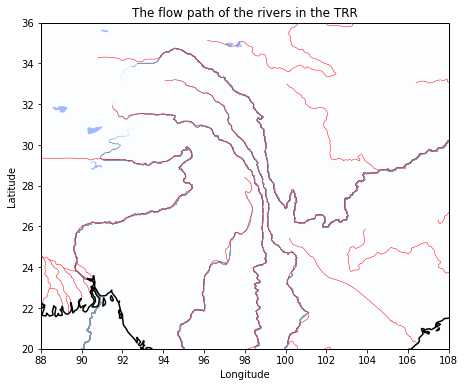

In [17]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# cartopy parameters
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                      edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),facecolor="none")
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                     edgecolor="blue", facecolor="blue")
prj_base  = ccrs.PlateCarree() 


# w = ccs_arr 
# flow_arr2 = flow_arr.copy()
# flow_arr2[np.where(w==0)]=0
# data_img  = np.flipud(flow_arr2)

w = trunk_arr2
flow_arr2 = flow_arr.copy()
flow_arr2[np.where(w==0)]=0
data_img2  = np.flipud(flow_arr2)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection=prj_base)
ax.set_extent(extent)

ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the rivers in the TRR')

#ax.imshow(data_img,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000,transform=prj_base)
ax.imshow(data_img2,extent=extent,cmap=cm.Blues,vmin=0, vmax=2000,transform=prj_base,alpha=0.5)

ax.add_feature(coastline, linewidth=1.5, edgecolor="Black", zorder=5)
ax.add_feature(rivers, linewidth=0.5, edgecolor="r", zorder=6)
ax.add_feature(lakes,     linewidth=0,   edgecolor="Blue", facecolor="#4477FF", zorder=7, alpha=0.5)

plt.show()
#plt.savefig(('TRR_Flowpath.png'),dpi=300)

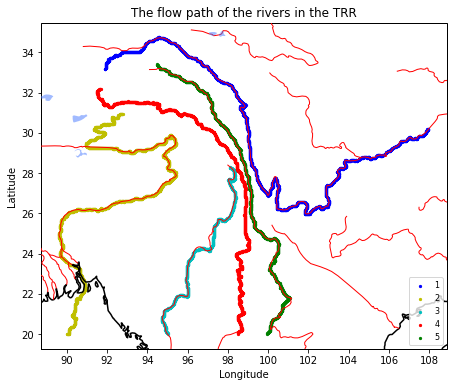

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks_area, xticks=xticks_area)
ax.set_title('The flow path of the rivers in the TRR')
labels = np.arange(1,len(ccs_id)+1)
colors =['b','y','c','r','g']
for i in range(0,len(labels)):
    fname_load = '../data/data_rivers/qixiang/river'+str(labels[i])+'.txt'
    river = np.loadtxt(fname_load)
    ax.scatter(river[:,0],river[:,1],label=labels[i],color=colors[i],s =5)
plt.legend(loc = 'lower right',prop = {'size':8}) 
ax.add_feature(coastline, linewidth=1.5, edgecolor="Black", zorder=5)
ax.add_feature(rivers,    linewidth=1.0, edgecolor="r", zorder=6)
ax.add_feature(lakes,     linewidth=0,   edgecolor="Blue", facecolor="#4477FF", zorder=7, alpha=0.5)